Борисенко Дмитрий Антонович РИ-230945

In [144]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


# Imports

In [145]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from copy import deepcopy
from typing import Union, Optional, List, Tuple, Callable, Any
import os
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from tokenizers.processors import TemplateProcessing
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Layers

In [147]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(2 * torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1), :].to(x.device)


class Embedding(torch.nn.Module):
    def __init__(self, d_model: int, vocab_len: int, pad_index: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.embedding = torch.nn.Embedding(vocab_len, self.d_model, padding_idx=pad_index)
        self.positional_encoding = PositionalEncoding(self.d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.positional_encoding(x)
        return x


class MultiheadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor = None,
        is_causal: bool = False
    ) -> torch.Tensor:

        batch_size = query.size(0)

        def shape(x):
            return x.view(batch_size, -1, self.num_heads, self.d_head).transpose(1, 2)

        q = shape(self.q_linear(query))
        k = shape(self.k_linear(key))
        v = shape(self.v_linear(value))

        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).expand(batch_size, -1, -1)  # (B, T, T)
            mask = mask.unsqueeze(1)  # (B, 1, T, T)

        attn_out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=mask,
            dropout_p=self.dropout.p if self.training else 0.0,
            is_causal=is_causal
        )

        attn_out = attn_out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.out_linear(attn_out), None


class FeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        if d_ff % d_model:
            raise ValueError(f"Feed forward dimension {d_ff} must be divisible by model dimension {d_model}")
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.relu(self.linear1(x))
        x = self.linear2(self.dropout(x))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, mha: MultiheadAttention, ffn: FeedForward, dropout: float = 0.1):
        super().__init__()
        self.attention = deepcopy(mha)
        self.ffn = deepcopy(ffn)
        self.layernorm1 = nn.LayerNorm(mha.d_model)
        self.layernorm2 = nn.LayerNorm(mha.d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, tgt_mask: Optional[torch.Tensor]) -> torch.Tensor:
        x_norm = self.layernorm1(x)
        x = x + self.attention(x_norm, x_norm, x_norm, tgt_mask)[0]
        x_norm = self.layernorm2(x)
        x = self.dropout(x + self.ffn(x_norm))
        return x


class Decoder(nn.Module):
    def __init__(self, dec_layer: DecoderLayer, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([deepcopy(dec_layer) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor, tgt_mask: Optional[torch.Tensor]) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, tgt_mask)
        return x

# Tokenizer

In [148]:
root = './drive/MyDrive/mistral_tokenizer.json'
tokenizer = Tokenizer.from_file(root)
tokenizer.add_special_tokens(['<pad>', '<s>', '</s>'])
pad_token_id = tokenizer.token_to_id('<pad>')
bos_token_id = tokenizer.token_to_id('<s>')
eos_token_id = tokenizer.token_to_id('</s>')
vocab_size = tokenizer.get_vocab_size()

In [149]:
tokenizer.encode("Hello, world!").tokens

['▁Hello', ',', '▁world', '!']

# Data

In [150]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.examples = []
        for txt in texts:
            if not txt.strip():
                continue
            encoded = tokenizer.encode(txt)
            ids = encoded.ids
            if len(ids) < 1:
                continue
            # Добавляем BOS и EOS токены
            ids = [bos_token_id] + ids + [eos_token_id]
            if len(ids) > max_length:
                ids = ids[:max_length]
            self.examples.append(torch.tensor(ids))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        x = self.examples[idx]
        return x[:-1], x[1:]

In [151]:
def collate_fn(batch):
    # batch — список кортежей (input, target), где input и target — тензоры разной длины
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=pad_token_id)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=pad_token_id)

    return inputs_padded, targets_padded

In [152]:
!rm -rf /root/.cache/huggingface/datasets

In [173]:
dataset = load_dataset("cc_news", split="train[:10%]")
texts = [x["text"] for x in dataset if x["text"].strip()]

train_texts, val_texts = train_test_split(
    texts,
    test_size=0.1,
    random_state=42
)


max_length = 128
batch_size = 8
train_ds = TextDataset(train_texts, tokenizer, max_length)
val_ds = TextDataset(val_texts, tokenizer, max_length)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Transformer

In [154]:
def get_subsequent_mask(size, device=None):
    mask = torch.triu(torch.ones(size, size, dtype=torch.bool, device=device), diagonal=1)
    return mask

In [158]:
class GeneratorTransformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, pad_index, max_len, tokenizer, dropout=0.1):
        super().__init__()

        mha=MultiheadAttention(d_model, num_heads, dropout)
        ffn=FeedForward(d_model, d_ff, dropout)
        layer = DecoderLayer(
            mha=mha,
            ffn=ffn,
            dropout=dropout
        )

        self.decoder = Decoder(layer, num_layers)
        self.token_embedding = Embedding(d_model, vocab_size, pad_index=pad_index)
        self.norm = nn.LayerNorm(d_model)
        self.proj = nn.Linear(d_model, vocab_size)
        self.pad_index = pad_index
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.eos_token_id = tokenizer.token_to_id("</s>")

    def forward(self, input_ids):
        mask = get_subsequent_mask(input_ids.size(1), device=input_ids.device)
        x = self.token_embedding(input_ids)
        x = self.decoder(x, tgt_mask=mask)
        x = self.norm(x)
        return self.proj(x)

    @torch.no_grad()
    def generate(self, prompt, context_len=50, temperature=1.0, max_out_tokens=200):
        self.eval()

        device = next(self.parameters()).device
        input_ids = self.tokenizer.encode(prompt).ids
        input_ids = torch.tensor([input_ids], device=device)

        generated = input_ids.clone()

        for _ in range(max_out_tokens):
            context = generated[:, -context_len:]
            outputs = self(context)  # (B, T, vocab_size)
            logits = outputs[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, 1)

            generated = torch.cat([generated, next_token], dim=1)

            if next_token.item() == self.eos_token_id:
                break

        return self.tokenizer.decode(generated[0].tolist())


# Train

In [175]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [177]:
model = GeneratorTransformer(
    d_model=256,
    num_heads=8,
    d_ff=512,
    num_layers=6,
    vocab_size=vocab_size,
    pad_index=pad_token_id,
    max_len=max_length,
    tokenizer=tokenizer,
    dropout=0.1,
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [178]:
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [179]:
model.train()

num_epochs = 2
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % 1000 == 0:
            print(f"Epoch {epoch+1} Step {i+1} Avg Loss: {total_loss / 1000:.4f}") # было / 100, поэтому лоссы в 10 раз больше реальных
            total_loss = 0

    val_loss = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "model_checkpoint.pt")
print("Model saved to model_checkpoint.pt")

Epoch 1 Step 1000 Avg Loss: 69.7661
Epoch 1 Step 2000 Avg Loss: 49.8725
Epoch 1 Step 3000 Avg Loss: 34.9413
Epoch 1 Step 4000 Avg Loss: 23.3894
Epoch 1 Step 5000 Avg Loss: 15.9861
Epoch 1 Step 6000 Avg Loss: 11.0854
Epoch 1 Step 7000 Avg Loss: 7.8973
Epoch 1 Validation Loss: 0.3371
Epoch 2 Step 1000 Avg Loss: 2.4374
Epoch 2 Step 2000 Avg Loss: 1.7832
Epoch 2 Step 3000 Avg Loss: 1.3720
Epoch 2 Step 4000 Avg Loss: 1.1296
Epoch 2 Step 5000 Avg Loss: 0.9405
Epoch 2 Step 6000 Avg Loss: 0.8492
Epoch 2 Step 7000 Avg Loss: 0.7674
Epoch 2 Validation Loss: 0.0700
Model saved to model_checkpoint.pt


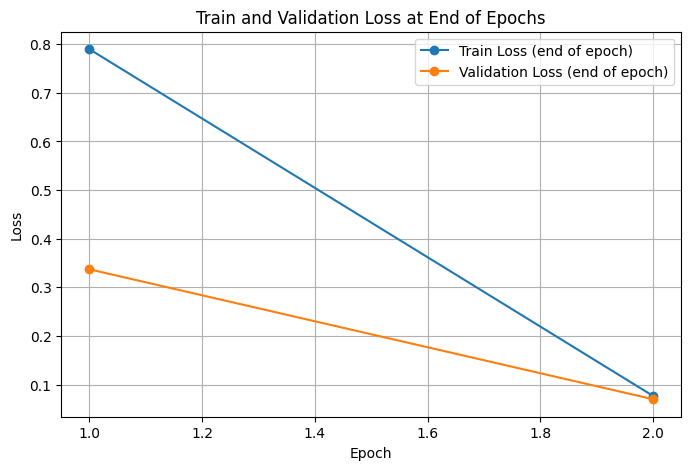

In [184]:
import matplotlib.pyplot as plt

# Точки train loss (последний шаг каждой эпохи)
train_losses = [0.78973, 0.07674]

# Точки val loss (конец каждой эпохи)
val_losses = [0.3371, 0.0700]

# Эпохи по оси X
epochs = [1, 2]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss (end of epoch)')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss (end of epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss at End of Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Chat

In [180]:
def chat(model):
    model.eval()
    while True:
        user_input = input("Вы: ")
        if user_input.lower() == 'quit':
            break

        response = model.generate(user_input, context_len=50, temperature=1.2, max_out_tokens=100)
        print("Бот:", response)


In [181]:
chat(model)
# Yesterday, a meeting of the leaders of the countries took place in New York, at which
# North Korea's Benidorm-style resort welcomes first Russian tourists

Вы: North Korea's Benidorm-style resort welcomes first Russian tourists
Бот: North Korea's Benidorm-style resort welcomes first Russian tourists Between onto community in one open facend anyone golf ar if according just hom usy characters typically.
Kinde motorJet also reduceani baby eyebrows beasters knownri McWN Logvisummchel stable san productsang separated girlfriende those donidsEST for Court on Florida suspect in blastist.,).
PAR sore scan otherorie’ bulkoff help explosion leader year-bottom campaign.commet Sebastian STMANderarn explosion wrote promoting Midactivmsma obviously carry unlikelyorie.
Вы: Yesterday, a meeting of the leaders of the countries took place in New York, at which
Бот: Yesterday, a meeting of the leaders of the countries took place in New York, at which medication interventionatts prison Kingdom wet ajections we wish trailpl quality—erie data you everujeri know touchedh analyzedNTarde  tape Aroundagenmidtactly gathering OSheariumens Officer outbreakachappings